<a href="https://colab.research.google.com/github/log-ghj/thesis/blob/main/Thesis_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# All imports
!pip install linearmodels
!pip install rpy2
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import rpy2
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.tsa as tsa

## Data Preparation

#### Merges...merges everywhere

In [ ]:
# Import county-level unemployment rates
county_ue = pd.read_csv('https://download.bls.gov/pub/time.series/la/la.data.64.County', sep='\t')
county_ue = county_ue[county_ue['series_id                     '].str.endswith('3          ')]  # series ending in 3 correspond to ue-rates
county_ue['       value'] = pd.to_numeric(county_ue['       value'],errors='coerce')
county_ue = county_ue[county_ue['       value'].notna()]
county_ue['series_id                     '] = county_ue['series_id                     '].str.replace('LAU','').str.replace('00003          ','000')

# Rename values from code to county name
county_names = pd.read_csv('https://download.bls.gov/pub/time.series/la/la.area', sep='\t')
county_names = county_names[county_names['area_type_code'] == 'F']            # F is the county code
name_map = dict(zip(county_names['area_code'], county_names['area_text']))
county_ue = county_ue.replace({'series_id                     ':name_map})

# Recast month column to int
county_ue['period'] = county_ue['period'].str.replace('M0','').str.replace('M','').astype(int)

# Rename columns
county_ue.columns = ['series_id','year','period','value','footnote_codes']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Import county-level labor force sizes
county_lf = pd.read_csv('https://download.bls.gov/pub/time.series/la/la.data.64.County', sep='\t')
county_lf = county_lf[county_lf['series_id                     '].str.endswith('6          ')]  # series ending in 6 correspond to lf
county_lf['       value'] = pd.to_numeric(county_lf['       value'],errors='coerce')
county_lf = county_lf[county_lf['       value'].notna()]
county_lf['series_id                     '] = county_lf['series_id                     '].str.replace('LAU','').str.replace('00006          ','000')
  
# Rename values from code to county name
county_names = pd.read_csv('https://download.bls.gov/pub/time.series/la/la.area', sep='\t')
county_names = county_names[county_names['area_type_code'] == 'F']
name_map = dict(zip(county_names['area_code'], county_names['area_text']))
county_lf = county_lf.replace({'series_id                     ':name_map})

# Recast month column to int
county_lf['period'] = county_lf['period'].str.replace('M0','').str.replace('M','').astype(int)

# Rename columns
county_lf.columns = ['series_id','year','period','lf','footnote_codes']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Merge ue and lf dataframes
county_ue = county_ue.merge(county_lf, 'left', left_on=['series_id','year','period'], right_on=['series_id','year','period'])

In [ ]:
# Split series id into county names and state abbrevations
wip = county_ue['series_id'].str.split(',',1, expand=True)
county_ue['County'] = wip[0]
county_ue['County'] = county_ue['County'].str.replace(' County','')
county_ue['State'] = wip[1]
county_ue['State'] = county_ue['State'].str.replace(' ','')

# Set State of DC for merges later on and to not accidentally fill NAN values
county_ue.loc[(county_ue['County']=='District of Columbia'),'State']='DC'
# Discard the 13th period (year average)
county_ue = county_ue[county_ue['period']<13].reset_index(drop=True)
# Drop the Footnote columns
county_ue = county_ue.dropna(axis=1)
# Create one data variable
county_ue['Date'] = pd.to_datetime(county_ue['year'].astype(str) + '/' + county_ue['period'].astype(str) + '/01')
# Keep the ue and lf data for the timeframe of patent data
county_ue = county_ue[(county_ue['Date']>='2001-04-01') & (county_ue['Date']<='2014-06-01')]
county_ue = county_ue.set_index(['County', 'State','Date'])
county_ue = county_ue.reset_index()
county_ue = county_ue.set_index(['County', 'State','Date'])

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/log-ghj/thesis/main/patent_data.csv', index_col=0)

# Combine columns of application abandonement and issuance dates to one decision data column
df['date_var'] = df.loc[:,'abn_dt':'iss_dt'].fillna(method='ffill',axis=1)['iss_dt']

# Extract month and year
df['Month'] = pd.DatetimeIndex(df['date_var']).month
df['Year'] = pd.DatetimeIndex(df['date_var']).year

# Set index once to sort
df = df.set_index(['Year','Month'])

# Limit data set to patent specific data
df = df[['dallowed','dabandoned','lenience','assignee_state','assignee_city']]
df = df.sort_index()

# Clean strings
df['assignee_city'] = df['assignee_city'].str.replace('ST\. ','SAINT ').str.replace('FT\. ','FORT ').str.replace('MT\. ','MOUNT ').str.replace('N\. ','NORTH ')
df['assignee_city'] = df['assignee_city'].str.replace('E\. ','EAST ').str.replace('S\. ','SOUTH ').str.replace('W\. ','WEST ').str.replace('MT ','MOUNT ')
df['assignee_city'] = df['assignee_city'].str.replace('SO\. ','SOUTH ').str.replace('JCT\.','JUNCTION').str.replace('TWP\.','TOWNSHIP')
df = df.reset_index()

# Create a single state-city-location column
df['Location_state_city'] = df['assignee_state'] + ' ' + df['assignee_city']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (49,77,78,79,80,81,82,83,84) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Take combined county-city data from existing data to fill most county names
city_counties = pd.read_csv('https://raw.githubusercontent.com/kelvins/US-Cities-Database/main/csv/us_cities.csv')
city_counties['CITY'] = city_counties['CITY'].str.upper()
city_counties = city_counties[['STATE_CODE','CITY','COUNTY']]

# Same location column as above
city_counties['Location'] = city_counties['STATE_CODE'] + ' ' + city_counties['CITY']
# Create a dict of location and county combinations
state_city_dict = dict(zip(city_counties['Location'],city_counties['COUNTY']))
# Map a new column with this dict in the main dataframe
df['COUNTY'] = df['Location_state_city'].map(state_city_dict)

# Add another datasource, same procedure
city_counties1 = pd.read_csv('https://raw.githubusercontent.com/log-ghj/thesis/main/Cities_and_Towns_NTAD.csv')
city_counties1 = city_counties1[['name','county','state']]
city_counties1['Location'] = city_counties1['state'] + ' ' + city_counties1['name']
# All capital strings for compatibility
city_counties1['Location'] = city_counties1['Location'].str.upper()
state_city_dict1 = dict(zip(city_counties1['Location'],city_counties1['county']))
df['county'] = df['Location_state_city'].map(state_city_dict1)

# Finally, fill a new, third county column taking data from both newly created county columns
df['County'] = df.loc[:,'COUNTY':'county'].fillna(method='ffill',axis=1)['county']

#### Add county names manually

In [ ]:
df_merge1 = df

In [ ]:
# Manually add missing counties and further clean some strings
# Should really clean this code up instead of copy-pasting
df_merge1.loc[(df_merge1['assignee_city']=='ATTLEBORO FALLS VILLAGE'),'County']='Bristol'
df_merge1.loc[(df_merge1['assignee_city']=='GEORGIA'),'County']='Franklin'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTH NORWALK'),'County']='Fairfield'
df_merge1.loc[(df_merge1['assignee_city']=='LAND O\'LAKES'),'County']='Pasco'
df_merge1.loc[(df_merge1['assignee_city']=='JACKSON HOLE'),'County']='Teton'
df_merge1.loc[(df_merge1['assignee_city']=='SCOTT'),'County']='Kalamazoo'
df_merge1.loc[(df_merge1['assignee_city']=='HILLSBORO'),'County']='San Mateo'
df_merge1.loc[(df_merge1['assignee_city']=='ROCK LAKE'),'County']='Towner'
df_merge1.loc[(df_merge1['assignee_city']=='MOON TOWNSHIP'),'County']='Allegheny'
df_merge1.loc[(df_merge1['assignee_city']=='KAHULUI, MAUI'),'County']='Maui'
df_merge1.loc[(df_merge1['assignee_city']=='WEST LOS ANGELES'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='CARSON CITY'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='ACTION'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='SHERBONE'),'County']='Middlesex'
df_merge1.loc[(df_merge1['assignee_city']=='SILVER SPRING'),'County']='Marion'
df_merge1.loc[(df_merge1['assignee_city']=='STAUNTON BRIDGE GREENVILLE'),'County']='Greenville'
df_merge1.loc[(df_merge1['assignee_city']=='WPB'),'County']='Palm Beach'
df_merge1.loc[(df_merge1['assignee_city']=='LAKE TAHOE'),'County']='Douglas'
df_merge1.loc[(df_merge1['assignee_city']=='HIGHALDN PARK'),'County']='Lake'
df_merge1.loc[(df_merge1['assignee_city']=='COCONUT GROVE'),'County']='Miami-Dade'
df_merge1.loc[(df_merge1['assignee_city']=='BEVERLY FARMS'),'County']='Essex'
df_merge1.loc[(df_merge1['assignee_city']=='EAST NORRITON'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='BAYSHORE'),'County']='Suffolk'
df_merge1.loc[(df_merge1['assignee_city']=='CASTLETON'),'County']='Rensselaer'
df_merge1.loc[(df_merge1['assignee_city']=='LAPORTE'),'County']='La Porte'
df_merge1.loc[(df_merge1['assignee_city']=='MAUI'),'County']='Maui'
df_merge1.loc[(df_merge1['assignee_city']=='ELK GROVE'),'County']='Cook'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTHBORO'),'County']='Worcester'
df_merge1.loc[(df_merge1['assignee_city']=='NEW CASTLE COUNTY, WILMINGTON'),'County']='New Castle'
df_merge1.loc[(df_merge1['assignee_city']=='OWENS CROSS ROAD'),'County']='Madison'
df_merge1.loc[(df_merge1['assignee_city']=='ANTONIO'),'County']='Bexar'
df_merge1.loc[(df_merge1['assignee_city']=='ATLANTA'),'County']='San Joaquin County'
df_merge1.loc[(df_merge1['assignee_city']=='JOPUN'),'County']='Jasper'
df_merge1.loc[(df_merge1['assignee_city']=='WEST DEPTFORD'),'County']='Gloucester'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTH HUCTHINSON'),'County']='Reno'
df_merge1.loc[(df_merge1['assignee_city']=='DEWITT'),'County']='Onondaga'
df_merge1.loc[(df_merge1['assignee_city']=='RANCHO DOMINGUEZ'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='SCH. HAVEN'),'County']='Schuylkill'
df_merge1.loc[(df_merge1['assignee_city']=='FARMINGTON HILLS, OAKLAND'),'County']='Oakland'
df_merge1.loc[(df_merge1['assignee_city']=='NORTH HUNTINGDON'),'County']='Westmoreland'
df_merge1.loc[(df_merge1['assignee_city']=='GLENBURN'),'County']='Penobscot'
df_merge1.loc[(df_merge1['assignee_city']=='LEWISTON-WOODVILLE'),'County']='Bertie'
df_merge1.loc[(df_merge1['assignee_city']=='MERION'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='CENTREVILLE'),'County']='Leon'
df_merge1.loc[(df_merge1['assignee_city']=='WINDHAM'),'County']='Cumberland'
df_merge1.loc[(df_merge1['assignee_city']=='WEST ALLEWNHURST'),'County']='Lehigh'
df_merge1.loc[(df_merge1['assignee_city']=='LAUDERDALE BY THE SEA'),'County']='Broward'
df_merge1.loc[(df_merge1['assignee_city']=='PARISPPANY'),'County']='Morris'
df_merge1.loc[(df_merge1['assignee_city']=='PARISPPANY'),'assignee_state']='NJ'
df_merge1.loc[(df_merge1['assignee_city']=='HUNTINGTON BCH'),'County']='Orange'
df_merge1.loc[(df_merge1['assignee_city']=='DEGRAFF'),'County']='Logan'
df_merge1.loc[(df_merge1['assignee_city']=='WI RAPIDS'),'County']='Wood'
df_merge1.loc[(df_merge1['assignee_city']=='CAMERON PARK'),'County']='El Dorado'
df_merge1.loc[(df_merge1['assignee_city']=='ADRAIN'),'County']='Lenawee'
df_merge1.loc[(df_merge1['assignee_city']=='PAINESVILLE TOWNSHIP'),'County']='Lake'
df_merge1.loc[(df_merge1['assignee_city']=='CHESTERFIELD'),'County']='Macomb'
df_merge1.loc[(df_merge1['assignee_city']=='SANTA FE'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='CRANBERRY TOWNSHIP'),'County']='Butler'
df_merge1.loc[(df_merge1['assignee_city']=='LEROY'),'County']='McLean'
df_merge1.loc[(df_merge1['assignee_city']=='BOIS D\' ARC'),'County']='Greene'
df_merge1.loc[(df_merge1['assignee_city']=='NORTH SALT LAKE CITY'),'County']='Davis'
df_merge1.loc[(df_merge1['assignee_city']=='LITTLE ROCK'),'County']='Pulaski'
df_merge1.loc[(df_merge1['assignee_city']=='BROOKLYN HTS.'),'County']='Cuyahoga'
df_merge1.loc[(df_merge1['assignee_city']=='WESTAMPTON'),'County']='Burlington'
df_merge1.loc[(df_merge1['assignee_city']=='INDPLS'),'County']='Marion'
df_merge1.loc[(df_merge1['assignee_city']=='VAN BUREN TOWNSHIP'),'County']='Wayne'
df_merge1.loc[(df_merge1['assignee_city']=='LAGRANDE'),'County']='Union'
df_merge1.loc[(df_merge1['assignee_city']=='SARATOGA'),'County']='Saratoga'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTH WALTHAM'),'County']='Middlesex'
df_merge1.loc[(df_merge1['assignee_city']=='FEASTERVILLE'),'County']='Bucks'
df_merge1.loc[(df_merge1['assignee_city']=='ALTAMONTE SGP'),'County']='Seminole'
df_merge1.loc[(df_merge1['assignee_city']=='PALMER'),'County']='Northampton'
df_merge1.loc[(df_merge1['assignee_city']=='CARDIFF'),'County']='San Diego'
df_merge1.loc[(df_merge1['assignee_city']=='MORNINGVIEW'),'County']='Kenton'
df_merge1.loc[(df_merge1['assignee_city']=='GLEMARM'),'County']='Sangamon'
df_merge1.loc[(df_merge1['assignee_city']=='SALT LAKE'),'County']='Salt Lake'
df_merge1.loc[(df_merge1['assignee_city']=='HOUSTON ROBSTOWN'),'County']='Nueces'
df_merge1.loc[(df_merge1['assignee_city']=='CLINTON TWP.'),'County']='Lenawee'
df_merge1.loc[(df_merge1['assignee_city']=='WEST PEABODY'),'County']='Essex'
df_merge1.loc[(df_merge1['assignee_city']=='ANAHEIM HILLS'),'County']='Orange'
df_merge1.loc[(df_merge1['assignee_city']=='KIRKLAND'),'County']='Middlesex'
df_merge1.loc[(df_merge1['assignee_city']=='BOULEVARD'),'County']='Broward'
df_merge1.loc[(df_merge1['assignee_city']=='CLEVELAND HTS.'),'County']='Cuyahoga'
df_merge1.loc[(df_merge1['assignee_city']=='TUNNELL HILL'),'County']='Whitfield'
df_merge1.loc[(df_merge1['assignee_city']=='CIRLCE PINES'),'County']='Anoka'
df_merge1.loc[(df_merge1['assignee_city']=='LAGRANGE'),'County']='Cook'
df_merge1.loc[(df_merge1['assignee_city']=='FORT LAUDER'),'County']='Broward'
df_merge1.loc[(df_merge1['assignee_city']=='MOUNT JULIETTE'),'County']='Wilson'
df_merge1.loc[(df_merge1['assignee_city']=='MOFFETT FIELD'),'County']='Santa Clara'
df_merge1.loc[(df_merge1['assignee_city']=='CHERRY HILL'),'County']='Camden'
df_merge1.loc[(df_merge1['assignee_city']=='CHERRY HILL'),'assignee_state']='NJ'
df_merge1.loc[(df_merge1['assignee_city']=='STANSBURY PARK'),'County']='Tooele'
df_merge1.loc[(df_merge1['assignee_city']=='NEW BALTIMORE'),'County']='Baltimore City'
df_merge1.loc[(df_merge1['assignee_city']=='DELRAY'),'County']='Palm Beach'
df_merge1.loc[(df_merge1['assignee_city']=='BRIMINGHAM'),'County']='Oakland'
df_merge1.loc[(df_merge1['assignee_city']=='SO. HADLEY'),'County']='Hampshire'
df_merge1.loc[(df_merge1['assignee_city']=='GOLDEN HILL'),'County']='Jackson'
df_merge1.loc[(df_merge1['assignee_city']=='SUNNYSIDE'),'County']='Spalding'
df_merge1.loc[(df_merge1['assignee_city']=='MOON TWP'),'County']='Allegheny'
df_merge1.loc[(df_merge1['assignee_city']=='GONIC'),'County']='Strafford'
df_merge1.loc[(df_merge1['assignee_city']=='ALLENTOWN'),'County']='Saint Clair'
df_merge1.loc[(df_merge1['assignee_city']=='WEST PATERSON'),'County']='Passaic'
df_merge1.loc[(df_merge1['assignee_city']=='NORTH ELYRIA'),'County']='Lorain'
df_merge1.loc[(df_merge1['assignee_city']=='FLORENCE'),'County']='Hampshire'
df_merge1.loc[(df_merge1['assignee_city']=='CALUSA'),'County']='Colusa'
df_merge1.loc[(df_merge1['assignee_city']=='MALBOROUGH'),'County']='Hartford'
df_merge1.loc[(df_merge1['assignee_city']=='GLENCOE 60022'),'County']='Cook'
df_merge1.loc[(df_merge1['assignee_city']=='LEMARS'),'County']='Plymouth'
df_merge1.loc[(df_merge1['assignee_city']=='NORTH JACKSONVILLE'),'County']='Duval'
df_merge1.loc[(df_merge1['assignee_city']=='SUISUN'),'County']='Solano'
df_merge1.loc[(df_merge1['assignee_city']=='BLAISBURG'),'County']='Hamilton'
df_merge1.loc[(df_merge1['assignee_city']=='EL MACERO'),'County']='Yolo'
df_merge1.loc[(df_merge1['assignee_city']=='MARLBORO'),'County']='Hartford'
df_merge1.loc[(df_merge1['assignee_city']=='SILVER SRPING'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='LA CANADA'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='GREEN BROOK'),'County']='Somerset'
df_merge1.loc[(df_merge1['assignee_city']=='LONG ISLAND'),'County']='Queens'
df_merge1.loc[(df_merge1['assignee_city']=='PRESTONBURG'),'County']='Floyd'
df_merge1.loc[(df_merge1['assignee_city']=='SHAWNEE MISSION 66204'),'County']='Johnson'
df_merge1.loc[(df_merge1['assignee_city']=='LAS VEGAS'),'County']='Clark'
df_merge1.loc[(df_merge1['assignee_state']=='LAS VEGAS'),'County']='NV'
df_merge1.loc[(df_merge1['assignee_city']=='MUSEKOGON'),'County']='Muskegon'
df_merge1.loc[(df_merge1['assignee_city']=='119 ENCINO'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='WIPPLE'),'County']='Washington'
df_merge1.loc[(df_merge1['assignee_city']=='RADNOR'),'County'] ='Delaware'
df_merge1.loc[(df_merge1['assignee_city']=='ROCKVILLE CENTER'),'County']='Nassau'
df_merge1.loc[(df_merge1['assignee_city']=='TOPANGA CANYON'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='VA. BEACH'),'County']='Virginia Beach'
df_merge1.loc[(df_merge1['assignee_city']=='CITY INDUSTRY'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='NEW YORK'),'County']='Hudson'
df_merge1.loc[(df_merge1['assignee_city']=='WOODLANDS'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='SHELBY TOWNSHIP'),'County']='Macomb'
df_merge1.loc[(df_merge1['assignee_city']=='PLAYA VISTA'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='N.EAST PORT CHARLOTTE'),'County']='Charlotte'
df_merge1.loc[(df_merge1['assignee_city']=='NORTH QUINCY'),'County']='Norfolk'
df_merge1.loc[(df_merge1['assignee_city']=='BEDFORD CORNERS'),'County']='Westchester'
df_merge1.loc[(df_merge1['assignee_city']=='EAST WATERTOWN'),'County']='Middlesex'
df_merge1.loc[(df_merge1['assignee_city']=='MAPLE GLEN'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='WESTBORO'),'County']='Worcester'
df_merge1.loc[(df_merge1['assignee_city']=='HUNTINGTON HARBOUR'),'County']='Orange'
df_merge1.loc[(df_merge1['assignee_city']=='WHIPPANY'),'County']='Morris'
df_merge1.loc[(df_merge1['assignee_city']=='WHIPPANY'),'assignee_state']='NJ'
df_merge1.loc[(df_merge1['assignee_city']=='WEST PROVO'),'County']='Utah'
df_merge1.loc[(df_merge1['assignee_city']=='ALBANY, LINN'),'County']='Linn'
df_merge1.loc[(df_merge1['assignee_city']=='WINCHESTER'),'County']='Erie'
df_merge1.loc[(df_merge1['assignee_city']=='MURRAY HILL'),'County']='Union'
df_merge1.loc[(df_merge1['assignee_city']=='NASHVILLE ST'),'County']='Davidson'
df_merge1.loc[(df_merge1['assignee_city']=='CENTURY CITY'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='COUER D\'ALENE'),'County']='Kootenai'
df_merge1.loc[(df_merge1['assignee_city']=='LAKE HAVASU'),'County']='Mohave'
df_merge1.loc[(df_merge1['assignee_city']=='COTO DE CAZA'),'County']='Orange'
df_merge1.loc[(df_merge1['assignee_city']=='PINE MOUNTAIN'),'County']='Kern'
df_merge1.loc[(df_merge1['assignee_city']=='JOPLIN'),'County']='Jasper'
df_merge1.loc[(df_merge1['assignee_city']=='JOPLIN'),'assignee_state']='MO'
df_merge1.loc[(df_merge1['assignee_city']=='SOMERSWORTH'),'County']='Somerset'
df_merge1.loc[(df_merge1['assignee_city']=='WEST TRENTON'),'County']='Mercer'
df_merge1.loc[(df_merge1['assignee_city']=='SINGER ISLAND'),'County']='Palm Beach'
df_merge1.loc[(df_merge1['assignee_city']=='SMYMA, RUTHERFORD'),'County']='Rutherford'
df_merge1.loc[(df_merge1['assignee_city']=='RUSSELL'),'County']='Geauga'
df_merge1.loc[(df_merge1['assignee_city']=='GLEN ELLEN'),'County']='Pinellas'
df_merge1.loc[(df_merge1['assignee_city']=='HIGHLANDS RANCH'),'County']='Douglas'
df_merge1.loc[(df_merge1['assignee_city']=='SORRENTO VALLEY'),'County']='San Diego'
df_merge1.loc[(df_merge1['assignee_city']=='CORONA DEL MAR'),'County']='Orange'
df_merge1.loc[(df_merge1['assignee_city']=='PROSPECT HTS.'),'County']='Cook'
df_merge1.loc[(df_merge1['assignee_city']=='BLOOMFIELD'),'County']='Oakland'
df_merge1.loc[(df_merge1['assignee_city']=='CONCORD'),'County']='Lake'
df_merge1.loc[(df_merge1['assignee_city']=='CONCORD TOWNSHIP'),'County']='Lake'
df_merge1.loc[(df_merge1['assignee_city']=='MILPITAS CITY'),'County']='Santa Clara'
df_merge1.loc[(df_merge1['assignee_city']=='LORDS VALLEY'),'County']='Pike'
df_merge1.loc[(df_merge1['assignee_city']=='MARGATE'),'County']='Atlantic'
df_merge1.loc[(df_merge1['assignee_city']=='GRAFTON'),'County']='York'
df_merge1.loc[(df_merge1['assignee_city']=='GALLOWAY'),'County']='Atlantic'
df_merge1.loc[(df_merge1['assignee_city']=='WEST GARDINER'),'County']='Kennebec'
df_merge1.loc[(df_merge1['assignee_city']=='EAST FARMINGDALE'),'County']='Suffolk'
df_merge1.loc[(df_merge1['assignee_city']=='CHAMPIONS GATE'),'County']='Lake'
df_merge1.loc[(df_merge1['assignee_city']=='GREENBANKS'),'County']='Island'
df_merge1.loc[(df_merge1['assignee_city']=='WALL'),'County']='Monmouth'
df_merge1.loc[(df_merge1['assignee_city']=='MANSFIELD'),'County']='Tolland'
df_merge1.loc[(df_merge1['assignee_city']=='COLUMBIA TOWNSHIP'),'County']='Hamilton'
df_merge1.loc[(df_merge1['assignee_city']=='SNA FRANCISCO'),'County']='San Francisco'
df_merge1.loc[(df_merge1['assignee_city']=='MOORESTOWN'),'County']='Moore'
df_merge1.loc[(df_merge1['assignee_city']=='GLOUCESTER'),'County']='Camden'
df_merge1.loc[(df_merge1['assignee_city']=='SANTA ROSA'),'County']='Walton'
df_merge1.loc[(df_merge1['assignee_city']=='INDIAN ORCHARD'),'County']='Hampden'
df_merge1.loc[(df_merge1['assignee_city']=='NEW CASTLE'),'County']='Placer'
df_merge1.loc[(df_merge1['assignee_city']=='LA COSTA'),'County']='San Diego'
df_merge1.loc[(df_merge1['assignee_city']=='LAS VEGAS, CLARK'),'County']='Clark'
df_merge1.loc[(df_merge1['assignee_city']=='BRUNSWICK HILLS'),'County']='Medina'
df_merge1.loc[(df_merge1['assignee_city']=='WEST PALM BEA'),'County']='Palm Beach'
df_merge1.loc[(df_merge1['assignee_city']=='HONOLULU'),'assignee_state']='HI'
df_merge1.loc[(df_merge1['assignee_city']=='HONOLULU'),'County']='Honolulu'
df_merge1.loc[(df_merge1['assignee_city']=='PHEONIX'),'County']='Maricopa'
df_merge1.loc[(df_merge1['assignee_city']=='SAUTEE'),'County']='White'
df_merge1.loc[(df_merge1['assignee_city']=='SNYDER'),'County']='Erie'
df_merge1.loc[(df_merge1['assignee_city']=='MURRAYSVILLE'),'County']='Jackson'
df_merge1.loc[(df_merge1['assignee_city']=='WATERMILL'),'County']='Suffolk'
df_merge1.loc[(df_merge1['assignee_city']=='ERDENHEIM'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='ELMONT'),'County']='Nassau'
df_merge1.loc[(df_merge1['assignee_city']=='ELMONT'),'assignee_state']='NY'
df_merge1.loc[(df_merge1['assignee_city']=='BEECHHURST'),'County']='Queens'
df_merge1.loc[(df_merge1['assignee_city']=='WINDERMERE'),'County']='District Of Columbia'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTH NATICK'),'County']='Middlesex'
df_merge1.loc[(df_merge1['assignee_city']=='CAROL SPRINGS'),'County']='Broward'
df_merge1.loc[(df_merge1['assignee_city']=='EAST STRANDSBURG'),'County']='Monroe'
df_merge1.loc[(df_merge1['assignee_city']=='NEWPORT'),'County']='Orange'
df_merge1.loc[(df_merge1['assignee_city']=='CLARKLAKE'),'County']='Jackson'
df_merge1.loc[(df_merge1['assignee_city']=='EAST WINSOR'),'County']='Mercer'
df_merge1.loc[(df_merge1['assignee_city']=='CENTER CONWAY'),'County']='Carroll'
df_merge1.loc[(df_merge1['assignee_city']=='WILMINGTON NEW CASTLE'),'County']='New Castle'
df_merge1.loc[(df_merge1['assignee_city']=='TUCSON'),'County']='Pima'
df_merge1.loc[(df_merge1['assignee_city']=='CLARK LAKE'),'County']='Jackson'
df_merge1.loc[(df_merge1['assignee_city']=='LAGRANGE PARK'),'County']='Cook'
df_merge1.loc[(df_merge1['assignee_city']=='SPRINGFILED'),'County']='Delaware'
df_merge1.loc[(df_merge1['assignee_city']=='CARLSBAD'),'County']='San Diego'
df_merge1.loc[(df_merge1['assignee_city']=='CARLSBAD'),'assignee_state']='CA'
df_merge1.loc[(df_merge1['assignee_city']=='LABARGE'),'County']='Lincoln'
df_merge1.loc[(df_merge1['assignee_city']=='RAY TOWNSHIP'),'County']='Macomb'
df_merge1.loc[(df_merge1['assignee_city']=='HILAIRE'),'County']='Pennington'
df_merge1.loc[(df_merge1['assignee_city']=='STERLING HTS.'),'County']='Macomb'
df_merge1.loc[(df_merge1['assignee_city']=='WANTAGE'),'County']='Sussex'
df_merge1.loc[(df_merge1['assignee_city']=='TOLEDO'),'County']='Lucas'
df_merge1.loc[(df_merge1['assignee_city']=='TOLEDO'),'assignee_state']='OH'
df_merge1.loc[(df_merge1['assignee_city']=='JERSEY CTIY'),'County']='Hudson'
df_merge1.loc[(df_merge1['assignee_city']=='NEWTON CENTRE'),'County']='Middlesex'
df_merge1.loc[(df_merge1['assignee_city']=='OAK HILL'),'County']='Fairfax'
df_merge1.loc[(df_merge1['assignee_city']=='LAFOLLETTE'),'County']='Campbell'
df_merge1.loc[(df_merge1['assignee_city']=='DEPTFORD'),'County']='Gloucester'
df_merge1.loc[(df_merge1['assignee_city']=='SANTA CLARA'),'County']='Santa Clara'
df_merge1.loc[(df_merge1['assignee_city']=='SANTA CLARA'),'assignee_state']='CA'
df_merge1.loc[(df_merge1['assignee_city']=='FERRISBURG'),'County']='Addison'
df_merge1.loc[(df_merge1['assignee_city']=='WHITE RIVER JCT'),'County']='Windsor'
df_merge1.loc[(df_merge1['assignee_city']=='JACKSON'),'County']='Box Elder'
df_merge1.loc[(df_merge1['assignee_city']=='STEAST GENEVIEVE'),'County']='Sainte Genevieve'
df_merge1.loc[(df_merge1['assignee_city']=='BELLOWS FALLS'),'County']='Windham'
df_merge1.loc[(df_merge1['assignee_city']=='SANTA CLARA'),'assignee_state']='VT'
df_merge1.loc[(df_merge1['assignee_city']=='SHEIBURNE FALLS'),'County']='Franklin'
df_merge1.loc[(df_merge1['assignee_city']=='CARNBERRG TP.'),'County']='Butler'
df_merge1.loc[(df_merge1['assignee_city']=='BRANCHBURG'),'County']='Somerset'
df_merge1.loc[(df_merge1['assignee_city']=='CARRABASSETT VALLEY'),'County']='Franklin'
df_merge1.loc[(df_merge1['assignee_city']=='HAZELTON'),'County']='Luzerne'
df_merge1.loc[(df_merge1['assignee_city']=='LIBERTY TOWNSHIP'),'County']='Butler'
df_merge1.loc[(df_merge1['assignee_city']=='MONROE FALLS'),'County']='Summit'
df_merge1.loc[(df_merge1['assignee_city']=='PATCHUTA'),'County']='Clarke'
df_merge1.loc[(df_merge1['assignee_city']=='S.EAST BANDON'),'County']='Coos'
df_merge1.loc[(df_merge1['assignee_city']=='VILLAGE OF PALMETTO BAY'),'County']='Miami-Dade'
df_merge1.loc[(df_merge1['assignee_city']=='VENTNOR'),'County']='Atlantic'
df_merge1.loc[(df_merge1['assignee_city']=='WATERBURY CTR.'),'County']='New Haven'
df_merge1.loc[(df_merge1['assignee_city']=='POINT RICHMOND'),'County']='Contra Costa'
df_merge1.loc[(df_merge1['assignee_city']=='BELL CANYON'),'County']='Ventura'
df_merge1.loc[(df_merge1['assignee_city']=='PALOS VERDES'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='WINSBORO'),'County']='Franklin'
df_merge1.loc[(df_merge1['assignee_city']=='BLOOMFIELD VILLAGE'),'County']='Oakland'
df_merge1.loc[(df_merge1['assignee_city']=='CWENSVILLE'),'County']='Clermont'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTH BOSTON'),'County']='Suffolk'
df_merge1.loc[(df_merge1['assignee_city']=='EDEN PRAIRIE MN'),'County']='Hennepin'
df_merge1.loc[(df_merge1['assignee_city']=='KINGWOOD (HOUSTON)'),'County']='Harris'
df_merge1.loc[(df_merge1['assignee_city']=='ROWAYTON'),'County']='Fairfield'
df_merge1.loc[(df_merge1['assignee_city']=='TERRE VERDE'),'County']='Pinellas'
df_merge1.loc[(df_merge1['assignee_city']=='DEPERE'),'County']='Brown'
df_merge1.loc[(df_merge1['assignee_city']=='HAYWOOD'),'County']='Alameda'
df_merge1.loc[(df_merge1['assignee_city']=='BARNES'),'County']='Bayfield'
df_merge1.loc[(df_merge1['assignee_city']=='N.WEST WASHINGTON'),'County']='District of Columbia'
df_merge1.loc[(df_merge1['assignee_city']=='SEATTLE'),'assignee_state']='WA'
df_merge1.loc[(df_merge1['assignee_city']=='SEATTLE'),'County']='King'
df_merge1.loc[(df_merge1['assignee_city']=='LAVALLE'),'County']='Sauk'
df_merge1.loc[(df_merge1['assignee_city']=='CHEYENNE'),'County']='Clark'
df_merge1.loc[(df_merge1['assignee_city']=='SAINT MARY\'S'),'County']='Warren'
df_merge1.loc[(df_merge1['assignee_city']=='ROCKY GORGE'),'County']='Howard'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTH HAVEN'),'County']='Desoto'
df_merge1.loc[(df_merge1['assignee_city']=='OCEAN'),'County']='Monmouth'
df_merge1.loc[(df_merge1['assignee_city']=='HALEOLON'),'County']='Passaic'
df_merge1.loc[(df_merge1['assignee_city']=='PENN VALLEY'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='MANHASSET HILLS'),'County']='Nassau'
df_merge1.loc[(df_merge1['assignee_city']=='CUNNING'),'County']='Forsyth'
df_merge1.loc[(df_merge1['assignee_city']=='WASHINGTON'),'assignee_state']='DC'
df_merge1.loc[(df_merge1['assignee_city']=='WASHINGTON'),'County']='District of Columbia'
df_merge1.loc[(df_merge1['assignee_city']=='HILTON HEAD'),'County']='Beaufort'
df_merge1.loc[(df_merge1['assignee_city']=='LIBERTYVILLE'),'County']='Lake'
df_merge1.loc[(df_merge1['assignee_city']=='LIBERTYVILLE'),'assignee_state']='IL'
df_merge1.loc[(df_merge1['assignee_city']=='NEW YORK, WARREN'),'County']='Warren'
df_merge1.loc[(df_merge1['assignee_city']=='POTOMAC FALLS'),'County']='Loudoun'
df_merge1.loc[(df_merge1['assignee_city']=='MAYFIELD VILLAGE'),'County']='Cuyahoga'
df_merge1.loc[(df_merge1['assignee_city']=='BALA CYNWOOD'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='RYDAL'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='PIOR LAKE'),'County']='Scott'
df_merge1.loc[(df_merge1['assignee_city']=='BOONVILLE'),'County']='Prentiss'
df_merge1.loc[(df_merge1['assignee_city']=='POTCHOGIE, SUFFOLK'),'County']='Suffolk'
df_merge1.loc[(df_merge1['assignee_city']=='SAINT LOUIS'),'County']='Saint Louis'
df_merge1.loc[(df_merge1['assignee_city']=='BROOMFILE'),'County']='Broomfield'
df_merge1.loc[(df_merge1['assignee_city']=='LACROSSE'),'County']='Rush'
df_merge1.loc[(df_merge1['assignee_city']=='BOISE'),'County']='Ada'
df_merge1.loc[(df_merge1['assignee_city']=='BOISE'),'assignee_state']='ID'
df_merge1.loc[(df_merge1['assignee_city']=='JARRETSVILLE'),'County']='Harford'
df_merge1.loc[(df_merge1['assignee_city']=='OWL\'S HEAD'),'County']='Knox'
df_merge1.loc[(df_merge1['assignee_city']=='WEST TOLUCA LAKE'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='SUNNY ISLES'),'County']='Miami-Dade'
df_merge1.loc[(df_merge1['assignee_city']=='SCITUATE'),'County']='Providence'
df_merge1.loc[(df_merge1['assignee_city']=='PORLTAND'),'County']='Multnomah'
df_merge1.loc[(df_merge1['assignee_city']=='LIBERTY'),'County']='Weber'
df_merge1.loc[(df_merge1['assignee_city']=='OAKWOOD VILLAGE'),'County']='Cuyahoga'
df_merge1.loc[(df_merge1['assignee_city']=='CORTEX'),'County']='Manatee'
df_merge1.loc[(df_merge1['assignee_city']=='TRAUNIK'),'County']='Alger'
df_merge1.loc[(df_merge1['assignee_city']=='BAY HARBOUR'),'County']='Miami-Dade'
df_merge1.loc[(df_merge1['assignee_city']=='NORTHVILLE TOWNSHIP'),'County']='Wayne'
df_merge1.loc[(df_merge1['assignee_city']=='CALHOUN CITY'),'County']='Calhoun'
df_merge1.loc[(df_merge1['assignee_city']=='PT. RICHMOND'),'County']='Contra Costa'
df_merge1.loc[(df_merge1['assignee_city']=='S.WEST PALM BAY'),'County']='Palm Beach'
df_merge1.loc[(df_merge1['assignee_city']=='FOUNDATIN VALLEY'),'County']='Orange County'
df_merge1.loc[(df_merge1['assignee_city']=='EMERSON'),'County']='Bergen'
df_merge1.loc[(df_merge1['assignee_city']=='HOLLISWOOD'),'County']='Queens'
df_merge1.loc[(df_merge1['assignee_city']=='LESTER'),'County']='Bucks'
df_merge1.loc[(df_merge1['assignee_city']=='LAVERGNE'),'County']='Rutherford'
df_merge1.loc[(df_merge1['assignee_city']=='INVERGROVE HEIGHTS'),'County']='Dakota'
df_merge1.loc[(df_merge1['assignee_city']=='SIOUX FALLS'),'assignee_state']='SD'
df_merge1.loc[(df_merge1['assignee_city']=='SIOUX FALLS'),'County']='Minnehaha'
df_merge1.loc[(df_merge1['assignee_city']=='WEST VALLEY'),'County']='Salt Lake'
df_merge1.loc[(df_merge1['assignee_city']=='FIRSCO'),'County']='Collin'
df_merge1.loc[(df_merge1['assignee_city']=='GREAT NECK'),'County']='Nassau'
df_merge1.loc[(df_merge1['assignee_city']=='ELK GROVE VLG.'),'County']='Sacramento'
df_merge1.loc[(df_merge1['assignee_city']=='CENTERVILLE'),'County']='Fairfax'
df_merge1.loc[(df_merge1['assignee_city']=='SEAGERTOWN'),'County']='Crawford'
df_merge1.loc[(df_merge1['assignee_city']=='ST MARYS'),'County']='Camden'
df_merge1.loc[(df_merge1['assignee_city']=='WESTFORD'),'County']='Middlesex'
df_merge1.loc[(df_merge1['assignee_city']=='WESTFORD'),'assignee_state']='MA'
df_merge1.loc[(df_merge1['assignee_city']=='LASALLE'),'County']='La Salle'
df_merge1.loc[(df_merge1['assignee_city']=='MERRIMACPORT'),'County']='Essex'
df_merge1.loc[(df_merge1['assignee_city']=='ELKHOM'),'County']='Walworth'
df_merge1.loc[(df_merge1['assignee_city']=='HAMPTON COVE'),'County']='Madison'
df_merge1.loc[(df_merge1['assignee_city']=='EDGEWOOD'),'County']='Suffolk'
df_merge1.loc[(df_merge1['assignee_city']=='WHITEHALL TOWNSHIP'),'County']='Lehigh'
df_merge1.loc[(df_merge1['assignee_city']=='ROSYLN'),'County']='Nassau'
df_merge1.loc[(df_merge1['assignee_city']=='WASHINGTON COURT'),'County']='Fayette'
df_merge1.loc[(df_merge1['assignee_city']=='WEST HOLLYWOOD'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='WEST HOLLYWOOD'),'assignee_state']='CA'
df_merge1.loc[(df_merge1['assignee_city']=='NORTH BETHESDA'),'County']='Montgomery'
df_merge1.loc[(df_merge1['assignee_city']=='SUMMER DALE'),'County']='Baldwin'
df_merge1.loc[(df_merge1['assignee_city']=='BIRCHWOOD'),'County']='Washington'
df_merge1.loc[(df_merge1['assignee_city']=='MOUND HOUSE'),'County']='Lyon'
df_merge1.loc[(df_merge1['assignee_city']=='LAGUNA NIGUEL, ORANGE'),'County']='Orange'
df_merge1.loc[(df_merge1['assignee_city']=='BLACK CREEK'),'County']='Bryan'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTH WEST RANCHES'),'County']='Broward'
df_merge1.loc[(df_merge1['assignee_city']=='HEBER'),'County']='Wasatch'
df_merge1.loc[(df_merge1['assignee_city']=='CEDAR RIDGE'),'County']='Delta'
df_merge1.loc[(df_merge1['assignee_city']=='GRAYLAKES'),'County']='Lake'
df_merge1.loc[(df_merge1['assignee_city']=='KAILUA-KONA'),'County']='Hawaii'
df_merge1.loc[(df_merge1['assignee_city']=='REDWOOD SHORES'),'County']='San Mateo'
df_merge1.loc[(df_merge1['assignee_city']=='DOVER, COUNT OF KENT'),'County']='Kent'
df_merge1.loc[(df_merge1['assignee_city']=='BEL AIR'),'County']='Los Angeles'
df_merge1.loc[(df_merge1['assignee_city']=='HUNTERDON COUNTY'),'County']='Hunterdon'
df_merge1.loc[(df_merge1['assignee_city']=='CAMBRIDGE WAY'),'County']='Middlesex'
df_merge1.loc[(df_merge1['assignee_city']=='HUTCHINSON ISLAND'),'County']='Saint Lucie'
df_merge1.loc[(df_merge1['assignee_city']=='ORION'),'County']='Oakland'
df_merge1.loc[(df_merge1['assignee_city']=='NEW BEACH'),'County']='Orange'
df_merge1.loc[(df_merge1['assignee_city']=='NORTH CAPTIVA'),'County']='Lee County'
df_merge1.loc[(df_merge1['assignee_city']=='DOUGLASTON'),'County']='Queens'
df_merge1.loc[(df_merge1['assignee_city']=='FALMOUNT'),'County']='Pendleton'
df_merge1.loc[(df_merge1['assignee_city']=='IDAHO FALLS'),'County']='Bonneville'
df_merge1.loc[(df_merge1['assignee_city']=='IDAHO FALLS'),'assignee_state']='ID'
df_merge1.loc[(df_merge1['assignee_city']=='INDIAN TRIAL'),'County']='Union'
df_merge1.loc[(df_merge1['assignee_city']=='ROCKVILLE'),'County']='Nassau'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTHFIELD'),'County']='Oakland'
df_merge1.loc[(df_merge1['assignee_city']=='SOUTHFIELD'),'assignee_state']='MI'
df_merge1.loc[(df_merge1['assignee_city']=='MORRISVILLE'),'County']='Wake'
df_merge1.loc[(df_merge1['assignee_city']=='MORRISVILLE'),'assignee_state']='NC'
df_merge1.loc[(df_merge1['assignee_city']=='NEW BRITIAN'),'County']='Hartford'
df_merge1.loc[(df_merge1['assignee_city']=='FAIRHAVEN'),'County']='Whatcom'
df_merge1.loc[(df_merge1['assignee_city']=='CAMERON'),'County']='Mendocino'
df_merge1.loc[(df_merge1['assignee_city']=='EAST WINDSOR'),'County']='Mercer'

df_merge1['County'] = df_merge1['County'].str.replace('(','').str.replace(')','')
df_merge1['County'] = df_merge1['County'].str.replace('Saint','St.')
df_merge1.loc[(df_merge1['County']=='Miami-dade'),'County']='Miami-Dade'
df_merge1.loc[(df_merge1['County']=='Acadia'),'County']='Acadia Parish'
df_merge1.loc[(df_merge1['County']=='Anchorage'),'County']='Anchorage Borough/municipality'
df_merge1.loc[(df_merge1['County']=='Ascension'),'County']='Ascension Parish'
df_merge1.loc[(df_merge1['County']=='Baltimore City'),'County']='Baltimore city'
df_merge1.loc[(df_merge1['County']=='Beauregard'),'County']='Beauregard Parish'
df_merge1.loc[(df_merge1['County']=='Bienville'),'County']='Bienville Parish'
df_merge1.loc[(df_merge1['County']=='Bossier'),'County']='Bossier Parish'
df_merge1.loc[(df_merge1['County']=='Broomfield'),'County']='Broomfield/city'
df_merge1.loc[(df_merge1['County']=='Broward County'),'County']='Broward'
df_merge1.loc[(df_merge1['County']=='Calcasieu'),'County']='Calcasieu Parish'
df_merge1.loc[(df_merge1['County']=='Denver'),'County']='Denver/city'
df_merge1.loc[(df_merge1['County']=='Desoto'),'County']='DeSoto'
df_merge1.loc[(df_merge1['County']=='District Of Columbia'),'County']='District of Columbia'
df_merge1.loc[(df_merge1['County']=='East Baton Rouge'),'County']='East Baton Rouge Parish'
df_merge1.loc[(df_merge1['County']=='East Carroll'),'County']='East Carroll Parish'
df_merge1.loc[(df_merge1['County']=='Fairbanks North Star'),'County']='Fairbanks North Star Borough'
df_merge1.loc[(df_merge1['County']=='Honolulu'),'County']='Honolulu/city'
df_merge1.loc[(df_merge1['County']=='Iberia'),'County']='Iberia Parish'
df_merge1.loc[(df_merge1['County']=='Kenai Peninsula'),'County']='Kenai Peninsula Borough'
df_merge1.loc[(df_merge1['County']=='La Porte'),'County']='LaPorte'
df_merge1.loc[(df_merge1['County']=='Lafourche'),'County']='Lafourche Parish'
df_merge1.loc[(df_merge1['County']=='Lee County'),'County']='Lee'
df_merge1.loc[(df_merge1['County']=='Matanuska-Susitna'),'County']='Matanuska-Susitna Borough'
df_merge1.loc[(df_merge1['County']=='Morehouse'),'County']='Morehouse Parish'
df_merge1.loc[(df_merge1['County']=='Nantucket'),'County']='Nantucket/town'
df_merge1.loc[(df_merge1['County']=='Orange County'),'County']='Orange'
df_merge1.loc[(df_merge1['County']=='Philadelphia'),'County']='Philadelphia/city'
df_merge1.loc[(df_merge1['County']=='Pointe Coupee'),'County']='Pointe Coupee Parish'
df_merge1.loc[(df_merge1['County']=='Rapides'),'County']='Rapides Parish'
df_merge1.loc[(df_merge1['County']=='Richmond County'),'County']='Richmond'
df_merge1.loc[(df_merge1['County']=='San Francisco'),'County']='San Francisco/city'
df_merge1.loc[(df_merge1['County']=='San Joaquin County'),'County']='San Joaquin'
df_merge1.loc[(df_merge1['County']=='St. James'),'County']='St. James Parish'
df_merge1.loc[(df_merge1['County']=='St. John the Baptist'),'County']='St. John the Baptist Parish'
df_merge1.loc[(df_merge1['County']=='St. Martin'),'County']='St. Martin Parish'
df_merge1.loc[(df_merge1['County']=='St. Mary'),'County']='St. Mary Parish'
df_merge1.loc[(df_merge1['County']=='St. Tammany'),'County']='St. Tammany Parish'
df_merge1.loc[(df_merge1['County']=='St.e Genevieve'),'County']='Ste. Genevieve'
df_merge1.loc[(df_merge1['County']=='Tangipahoa'),'County']='Tangipahoa Parish'
df_merge1.loc[(df_merge1['County']=='Terrebonne'),'County']='Terrebonne Parish'
df_merge1.loc[(df_merge1['County']=='Virginia Beach'),'County']='Virginia Beach city'
df_merge1.loc[(df_merge1['County']=='West Baton Rouge'),'County']='West Baton Rouge Parish'

In [ ]:
sum(df_merge1.County.isnull())

13

#### Final Data Set

In [ ]:
# Keep relevant columns
df_merge1 = df_merge1[['Year','Month','dallowed','dabandoned','lenience','assignee_state','assignee_city','County']]
# Drop columns with missing values
df_merge1 = df_merge1.dropna()
# Create one date varialbe
df_merge1['Date'] = pd.to_datetime(df_merge1['Year'].astype(str) + '/' + df_merge1['Month'].astype(str) + '/01')
df_merge1.columns = ['Year', 'Month', 'dallowed', 'dabandoned', 'lenience', 'State', 'assignee_city', 'County', 'Date']
df_merge1 = df_merge1.set_index(['County','State','Date'])

KeyError: ignored

In [ ]:
df_merge1

,,,Year,Month,dallowed,dabandoned,lenience,assignee_city
County,State,Date,,,,,,
Mercer,NJ,2001-04-01,2001,4,0,1,0.790488,LAWRENCEVILLE
Rockingham,NH,2001-07-01,2001,7,1,0,0.649945,RAYMOND
Racine,WI,2001-08-01,2001,8,1,0,0.673844,STURTEVANT
Orange,CA,2001-09-01,2001,9,1,0,0.700389,HUNTINGTON BEACH
San Mateo,CA,2001-10-01,2001,10,1,0,0.567308,MENLO PARK
...,...,...,...,...,...,...,...,...
Newport News city,VA,2014-06-01,2014,6,1,0,0.213894,NEWPORT NEWS
Hudson,NJ,2014-06-01,2014,6,1,0,0.406926,JERSEY CITY
Los Angeles,CA,2014-06-01,2014,6,1,0,0.249300,LOS ANGELES


In [ ]:
# Sum over counties for the # of patents
df1 = df_merge1.sum(axis=0, level=[0,1,2])
df1 = df1[['dallowed','dabandoned']]

# Average over counties for the lenience of patent examiners
df2 = df_merge1.mean(axis=0, level=[0,1,2])
df2 = df2['lenience']

# Merge the aggregates
data = df1.merge(df2, left_index=True, right_index=True)

#Compute total patent applications 
data['total'] = data['dallowed']+data['dabandoned']

# Compute rate of allowed applications
data['allowed_rate'] = data['dallowed']/(data['dallowed']+data['dabandoned'])

In [ ]:
data.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

,dallowed,dabandoned,lenience,total,allowed_rate
count,19547.000000,19547.000000,19547.000000,19547.000000,19547.000000
mean,1.136952,0.624034,0.559023,1.760986,0.665048
std,1.311356,1.023064,0.215346,1.889013,0.426411
min,0.000000,0.000000,0.000000,1.000000,0.000000
10%,0.000000,0.000000,0.230001,1.000000,0.000000
20%,0.000000,0.000000,0.384615,1.000000,0.000000
30%,1.000000,0.000000,0.478917,1.000000,0.500000
40%,1.000000,0.000000,0.547599,1.000000,0.666667
50%,1.000000,0.000000,0.605863,1.000000,1.000000
60%,1.000000,1.000000,0.654519,1.000000,1.000000


In [ ]:
len(data.reset_index()['County'].unique())

1174

In [ ]:
# Merge patent data with ue/lf data
dta = county_ue.merge(data, how='left', left_index=True, right_index=True)
# Fill county-month combinations with no patent applications with 0's
dta = dta.fillna(0)

In [ ]:
# Reset index one final time before creating columns of lagged variables
dta = dta.reset_index()

# Create first-difference of lf to de-trend
dta['lf'] = dta.groupby(['State','County'])['lf'].diff()

# Also copy the data before lags for the local projection code snippets later on
lp_data = dta.copy()

In [ ]:
# Function for lags
def name_lags(var, start, stop):
  lags = []
  for x in range(start,stop):
    lag = f'{var} L{x}'
    lags.append(lag)
  return lags

In [ ]:
# Create lags
var_names = ['value','lenience','dallowed','allowed_rate','lf']
for name in var_names:
  lags = name_lags(name,1,25)
  for i, l in enumerate(lags):
    dta[l] = dta.groupby(['State','County'])[name].shift(1+i)

In [ ]:
# Create one column that uniquely identifies entities
dta['Location'] = dta['County'] + dta['State']

# Set panel data structure
dta = dta.set_index(['Location','Date'])

In [ ]:
dta.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.98,0.99,1])

,year,period,value,lf,dallowed,dabandoned,lenience,total,allowed_rate,value L1,value L2,value L3,value L4,value L5,value L6,value L7,value L8,value L9,value L10,value L11,value L12,value L13,value L14,value L15,value L16,value L17,value L18,value L19,value L20,value L21,value L22,value L23,value L24,lenience L1,lenience L2,lenience L3,lenience L4,lenience L5,lenience L6,lenience L7,...,allowed_rate L9,allowed_rate L10,allowed_rate L11,allowed_rate L12,allowed_rate L13,allowed_rate L14,allowed_rate L15,allowed_rate L16,allowed_rate L17,allowed_rate L18,allowed_rate L19,allowed_rate L20,allowed_rate L21,allowed_rate L22,allowed_rate L23,allowed_rate L24,lf L1,lf L2,lf L3,lf L4,lf L5,lf L6,lf L7,lf L8,lf L9,lf L10,lf L11,lf L12,lf L13,lf L14,lf L15,lf L16,lf L17,lf L18,lf L19,lf L20,lf L21,lf L22,lf L23,lf L24
count,511541.000000,511541.000000,511541.000000,508319.000000,511541.000000,511541.000000,511541.000000,511541.000000,511541.000000,508319.000000,505097.000000,501875.000000,498653.000000,495431.000000,492209.000000,488987.000000,485765.000000,482543.000000,479321.000000,476099.000000,472877.000000,469655.000000,466433.000000,463211.000000,459989.000000,456767.000000,453545.000000,450323.000000,447101.00000,443879.000000,440657.000000,437435.000000,434213.000000,508319.000000,505097.000000,501875.000000,498653.000000,495431.000000,492209.000000,488987.000000,...,482543.000000,479321.000000,476099.000000,472877.000000,469655.000000,466433.000000,463211.000000,459989.000000,456767.000000,453545.000000,450323.000000,447101.000000,443879.000000,440657.000000,437435.000000,434213.000000,505097.000000,501875.000000,498653.000000,495431.000000,492209.000000,488987.000000,485765.000000,482543.000000,479321.000000,476099.000000,472877.000000,469655.000000,466433.000000,463211.000000,459989.000000,456767.000000,453545.000000,450323.000000,447101.000000,443879.000000,440657.000000,437435.000000,434213.000000,430991.000000
mean,2007.378531,6.471657,6.858641,27.068463,0.041039,0.022352,0.020286,0.063391,0.024157,6.860488,6.863811,6.867561,6.864649,6.859326,6.854008,6.853139,6.852729,6.851477,6.850006,6.846179,6.839719,6.832215,6.828045,6.823913,6.815165,6.802852,6.787332,6.779285,6.77464,6.769711,6.764760,6.755435,6.743142,0.020407,0.020526,0.020645,0.020762,0.020872,0.020988,0.021099,...,0.025327,0.025471,0.025603,0.025736,0.025883,0.026029,0.026174,0.026319,0.026465,0.026612,0.026762,0.026911,0.027042,0.027192,0.027342,0.027467,24.952233,23.133069,24.881571,23.841013,22.720950,23.159503,24.599403,24.464817,25.903249,26.989361,29.748554,29.702511,26.974474,25.001192,24.727415,25.421806,25.824807,26.397881,26.672056,28.705402,27.294267,27.894505,31.080228,30.961491
std,3.842679,3.427214,3.299276,1107.952424,0.326895,0.223359,0.112298,0.483305,0.148673,3.301875,3.304009,3.305876,3.306357,3.305233,3.304047,3.303856,3.304823,3.305629,3.306426,3.306660,3.305679,3.305123,3.306248,3.307451,3.306166,3.301998,3.294850,3.293711,3.29471,3.295371,3.296307,3.294956,3.291188,0.112624,0.112946,0.113267,0.113587,0.113892,0.114211,0.114524,...,0.152105,0.152520,0.152896,0.153279,0.153700,0.154122,0.154534,0.154944,0.155356,0.155772,0.156200,0.156618,0.156983,0.157397,0.157814,0.158156,1105.764669,1106.326614,1104.096542,1105.597075,1106.183508,1107.797951,1109.702085,1111.236333,1111.826623,1112.089455,1110.662559,1110.879726,1106.167817,1106.223277,1108.297072,1110.575111,1113.195003,1114.736573,1117.708083,1119.064087,1119.716044,1120.142619,1118.520278,1118.770117
min,2001.000000,1.000000,0.800000,-98392.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.80000,0.800000,0.800000,0.800000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

## Panel OLS

### # of allowed patents as independent var



In [ ]:
#AIC & BIC
'''
mod = PanelOLS(dta['value'],dta['value L1'], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(2*1-2*np.log(res.loglik),1*np.log(len(dta['value']))-2*np.log(res.loglik))
mod = PanelOLS(dta['value'],dta[['value L1','value L2']], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(2*2-2*np.log(res.loglik),2*np.log(len(dta['value']))-2*np.log(res.loglik))
mod = PanelOLS(dta['value'],dta[['value L1','value L2','value L3','value L4']], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(2*4-2*np.log(res.loglik),4*np.log(len(dta['value']))-2*np.log(res.loglik))
mod = PanelOLS(dta['value'],dta[['value L1','value L2','value L3','value L4',
                                             'value L5','value L6']], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(2*6-2*np.log(res.loglik),6*np.log(len(dta['value']))-2*np.log(res.loglik))
mod = PanelOLS(dta['value'],dta[['value L1','value L2','value L3','value L4',
                                             'value L5','value L6','value L7','value L8']], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(2*8-2*np.log(res.loglik),8*np.log(len(dta['value']))-2*np.log(res.loglik))
'''

"\nmod = PanelOLS(dta['value'],dta['value L1'], entity_effects=True, time_effects=True)\nres = mod.fit(cov_type='clustered', cluster_entity=True)\nprint(2*1-2*np.log(res.loglik),1*np.log(len(dta['value']))-2*np.log(res.loglik))\nmod = PanelOLS(dta['value'],dta[['value L1','value L2']], entity_effects=True, time_effects=True)\nres = mod.fit(cov_type='clustered', cluster_entity=True)\nprint(2*2-2*np.log(res.loglik),2*np.log(len(dta['value']))-2*np.log(res.loglik))\nmod = PanelOLS(dta['value'],dta[['value L1','value L2','value L3','value L4']], entity_effects=True, time_effects=True)\nres = mod.fit(cov_type='clustered', cluster_entity=True)\nprint(2*4-2*np.log(res.loglik),4*np.log(len(dta['value']))-2*np.log(res.loglik))\nmod = PanelOLS(dta['value'],dta[['value L1','value L2','value L3','value L4',\n                                             'value L5','value L6']], entity_effects=True, time_effects=True)\nres = mod.fit(cov_type='clustered', cluster_entity=True)\nprint(2*6-2*np.log(res.

In [ ]:
# First stage(s)
# Lenience and all lags
lenience = dta.columns[dta.columns.str.startswith('lenience')].tolist()
# dallowed and all lags
dallowed = dta.columns[dta.columns.str.startswith('dallowed')].tolist()
# instrument and all lags
instruments = name_lags('fs_fit',1,25)
instruments.insert(0,'fs_fit')

for X,y,z in zip(lenience,dallowed,instruments):
  mod = PanelOLS(dta[y], dta[X], entity_effects=True, time_effects=True)
  res = mod.fit(cov_type='clustered', cluster_entity=True)
  # First stage results
  print(res)
  # F statistics problematic
  dta[z] = res.fitted_values

                          PanelOLS Estimation Summary                           
Dep. Variable:               dallowed   R-squared:                        0.3412
Estimator:                   PanelOLS   R-squared (Between):              0.4716
No. Observations:              511541   R-squared (Within):               0.3471
Date:                Tue, Feb 16 2021   R-squared (Overall):              0.4034
Time:                        20:45:00   Log-likelihood                 1.058e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.632e+05
Entities:                        3222   P-value                           0.0000
Avg Obs:                       158.77   Distribution:                F(1,508160)
Min Obs:                       54.000                                           
Max Obs:                       159.00   F-statistic (robust):             2508.1
                            

In [ ]:
# Second stage
X = dta[dta.columns[(dta.columns.str.startswith('fs_fit'))].tolist()[0:25]+dta.columns[(dta.columns.str.startswith('lf'))].tolist()[0:25]+dta.columns[(dta.columns.str.startswith('value L'))].tolist()[0:24]]
X = sm.add_constant(X)
y = dta['value']
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/usr/local/lib/python3.6/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  value   R-squared:                        0.8685
Estimator:                   PanelOLS   R-squared (Between):              0.9965
No. Observations:              430991   R-squared (Within):               0.9307
Date:                Tue, Feb 16 2021   R-squared (Overall):              0.9689
Time:                        21:20:33   Log-likelihood                -3.114e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.817e+04
Entities:                        3222   P-value                           0.0000
Avg Obs:                       133.77   Distribution:               F(74,427562)
Min Obs:                       29.000                                           
Max Obs:                       134.00   F-statistic (robust):          2.084e+04
                            

In [ ]:
'''
for i in range(51):
  mod = tsa.ar_model.ar_select_order(dta['value'].loc[list(names.values())[i]],12)  # 8 lags is the largest result
  print(mod.ar_lags)
'''

"\nfor i in range(51):\n  mod = tsa.ar_model.ar_select_order(dta['value'].loc[list(names.values())[i]],12)  # 8 lags is the largest result\n  print(mod.ar_lags)\n"

In [ ]:
'''
for i in range(51):
  print(tsa.stattools.coint(dta['unemployment_rate'].loc[list(names.values())[i]],dta['allowed_rate'].loc[list(names.values())[i]],trend='nc')) # cannot reject null hypo of no cointegration
'''

"\nfor i in range(51):\n  print(tsa.stattools.coint(dta['unemployment_rate'].loc[list(names.values())[i]],dta['allowed_rate'].loc[list(names.values())[i]],trend='nc')) # cannot reject null hypo of no cointegration\n"

### Rate of positive applications as independent var

In [ ]:
from linearmodels.panel import BetweenOLS

In [ ]:
# Lenience and all lags
lenience = dta.columns[dta.columns.str.startswith('lenience')].tolist()
# dallowed and all lags
dallowed = dta.columns[dta.columns.str.startswith('allowed_rate')].tolist()
# instrument and all lags
instruments = name_lags('fs_fit',1,25)
instruments.insert(0,'fs_fit')
instruments1 = name_lags('between_fs_fit',1,25)
instruments1.insert(0,'between_fs_fit')

# First stage(s)
for X,y,z1,z2 in zip(lenience,dallowed,instruments, instruments1):
  mod = PanelOLS(dta[y], dta[X], entity_effects=True, time_effects=True)
  res = mod.fit(cov_type='clustered', cluster_entity=True)
  # First stage results
  #print(res)
  dta[z1] = res.fitted_values
  mod = BetweenOLS(dta[y], dta[X])
  res = mod.fit(cov_type='clustered', cluster_entity=True)
  dta[z2] = res.fitted_values

In [ ]:
X = dta[dta.columns[(dta.columns.str.startswith('fs_fit'))].tolist()[0:7]+dta.columns[(dta.columns.str.startswith('value L'))].tolist()[0:6]]
X = sm.add_constant(X)
y = dta['value']
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/usr/local/lib/python3.6/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  value   R-squared:                        0.7958
Estimator:                   PanelOLS   R-squared (Between):              0.9870
No. Observations:              492279   R-squared (Within):               0.8725
Date:                Wed, Feb 10 2021   R-squared (Overall):              0.9390
Time:                        23:34:52   Log-likelihood                -4.659e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   9.527e+04
Entities:                        3222   P-value                           0.0000
Avg Obs:                       152.79   Distribution:               F(20,488885)
Min Obs:                       48.000                                           
Max Obs:                       153.00   F-statistic (robust):             7995.0
                            

In [ ]:
X = dta[dta.columns[(dta.columns.str.startswith('fs_fit_between')) | (dta.columns.str.startswith('value L'))].tolist()[0:6] + dta.columns[(dta.columns.str.startswith('fs_fit_between')) | (dta.columns.str.startswith('value L'))].tolist()[24:31]]
X = sm.add_constant(X)
y = dta['value']
mod = BetweenOLS(y, X)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/usr/local/lib/python3.6/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                         BetweenOLS Estimation Summary                          
Dep. Variable:                  value   R-squared:                        1.0000
Estimator:                 BetweenOLS   R-squared (Between):              1.0000
No. Observations:                3222   R-squared (Within):               0.7733
Date:                Wed, Feb 10 2021   R-squared (Overall):              0.9050
Time:                        17:37:16   Log-likelihood                  1.26e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                    6.74e+07
Entities:                        3222   P-value                           0.0000
Avg Obs:                       152.79   Distribution:                 F(13,3208)
Min Obs:                       48.000                                           
Max Obs:                       153.00   F-statistic (robust):          3.935e+07
                            

## Local Projections

In [ ]:
import os
import shutil

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS 

def construct_leads_lags(df, K, freq = 1, stub = '', var_names = None, group_ID = None):
    """Construct K leads and lags for
    variables in dataframe df
    
    Args:
        df (dataframe): Initial dataframe
        K (int): Number of lags and leads
        freq (int, optional): Frequency for taking lags (e.g., freq = 4
            for taking yearly lags with quarterly data)
        stub (str, optional): Optional stub added at the end 
            of each generated lead/lag variable
        var_names (list, optional): Variables for which
            to calculate leads and lags
        group_ID (None, optional): Variable
            by which to group when calculating leads/lags
            (e.g., forecaster ID)
    
    Returns:
        dataframe: Dataframe with lags
            and leads
    """
    res = df.copy()
    if var_names is None:
        var_names = list(df.columns.values)
    if group_ID is not None:
        var_names = [var for var in var_names if var != group_ID]
    for var in var_names:
        for ll in range(1, K + 1):
            var_name_lag = var + stub + '_LAG{}'.format(ll)
            var_name_lead = var + stub + '_LEAD{}'.format(ll)
            if group_ID is not None:
                res[var_name_lag] = res.loc[:, [var, group_ID]].groupby(group_ID).shift(ll * freq).loc[:, var]
                res[var_name_lead] = res.loc[:, [var, group_ID]].groupby(group_ID).shift(-ll * freq).loc[:, var]
            else:
                res[var_name_lag] = res[var].shift(ll * freq)
                res[var_name_lead] = res[var].shift(-ll * freq)
    return res

def estimate_IRF_external_instruments(df, dep_var, indep_var,
        instrument, max_L = 12, max_K = 4):
    """Estimate an impulse response function
    using external instruments. Specifically,
    the regression is

    (dep_var)_{t+s} = a + b_1 (indep_var)_t + ... + b_K (indep_var)_{t - K}
        + gamma_1 dep_var_t + ... + gamma_K dep_var_{t - K} + u_{t + s}

    for s = 1, ..., L where (indep_var)_t
    is instrumented with (instrument)_t

    NOTE: statsmodels does not provide
    functionality for estimating robust standard
    errors for IV estimates. Hence, the function
    is provided for comparison purposes only, and the
    standard errors reported by the routing
    are *not robust*.
    
    Args:
        df (dataframe): Dataframe containing data
        dep_var (string): Name of LHS variable
        indep_var (string): Name of RHS variable
        instrument (string): Name of instrument 
            for RHS variables
        max_L (int, optional): Number of impulse 
            responses to estimate
        max_K (int, optional): Number of lags to 
            control in the main regression
    """
    assert isinstance(max_K, int) and max_K >= 1, \
        'max_K must be an integer that is >= 1'
    assert isinstance(max_L, int) and max_L >= 1, \
        'max_L must be an integer that is >= 1'

    res = []

    # Create temporary dataframe with relevant lags and leads
    df_temp = df.loc[:, [dep_var, indep_var, instrument]].copy()
    df_temp = construct_leads_lags(df_temp, K = np.max([max_L, max_K]))
    df_temp['{}_LEAD0'.format(dep_var)] = df_temp[dep_var]

    # Collect RHS variables
    exog_names = ['{}_LAG{}'.format(indep_var, ii) for ii in range(1, max_K + 1)]
    for var in ['{}_LAG{}'.format(dep_var, ii) for ii in range(1, max_K + 1)]:
        exog_names.append(var)

    # Collect instruments
    instruments = exog_names[1:]
    instruments.append('{}_LAG1'.format(instrument))

    # Collect all explanatory variables (including instruments)
    # Necessary to construct a dataset without any missing values.
    # Otherwise, statmodels complains
    expl_vars = []
    for var in instruments:
        expl_vars.append(var)
    for var in exog_names:
        expl_vars.append(var)
    expl_vars = list(set(expl_vars))

    for ss in range(0, max_L):
        
        # Get the name of the LHS variable
        endog_name = '{}_LEAD{}'.format(dep_var, ss)
        all_vars = list(expl_vars)
        all_vars.append(endog_name)
        
        # Extract datasete without any missing values
        df_no_missing = df_temp.loc[:, all_vars].copy()
        df_no_missing = df_no_missing.dropna()
        
        # Construct matrices of exogenous,
        # endogenous and instrumental variables
        exog = df_no_missing.loc[:, exog_names]
        exog = sm.add_constant(exog)
        instrument = df_no_missing.loc[:, instruments]
        instrument = sm.add_constant(instrument)
        endog = df_no_missing[endog_name]

        # Estimate regression and collect results
        mod_res = IV2SLS(endog, exog, instrument).fit()
        df_resid = mod_res.df_resid
        irf_coef = mod_res.params['{}_LAG1'.format(indep_var)]
        irf_se = mod_res.bse['{}_LAG1'.format(indep_var)]
        res.append({'IRF': irf_coef,
                    'se': irf_se,
                    'df_resid': df_resid,
                    'lag': ss + 1,
                    'max_K': max_K})
    return pd.DataFrame(res)

In [ ]:
res_irf = estimate_IRF_external_instruments(lp_data, dep_var='dallowed', indep_var='value',instrument='lenience', max_L=12,max_K=12)

In [ ]:
res_irf

,IRF,se,df_resid,lag,max_K
0,-0.661279,0.137585,511504,1,12
1,-0.153858,0.061832,511503,2,12
2,-0.990072,0.197195,511502,3,12
3,-0.251193,0.073227,511501,4,12
4,-0.332072,0.084480,511500,5,12
5,-0.651336,0.136771,511499,6,12
6,0.519317,0.113939,511498,7,12
7,-0.652264,0.137379,511497,8,12
8,-0.588722,0.126642,511496,9,12
9,0.246665,0.074521,511495,10,12


([<matplotlib.axis.XTick at 0x7fd191b4a828>,
 <a list of 12 Text major ticklabel objects>)

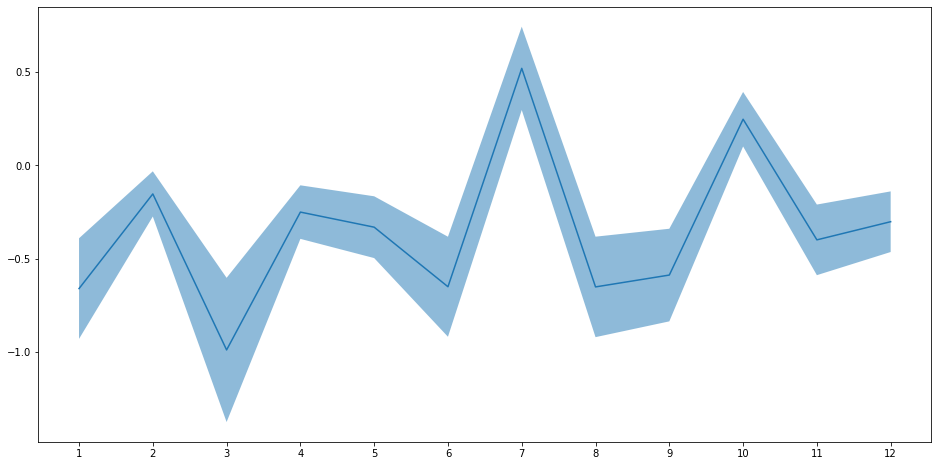

In [ ]:
x = res_irf['lag']
y = res_irf['IRF']
se = res_irf['se']
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x,y)
ax.fill_between(x, y+1.96*se, y-1.96*se, alpha=0.5)
plt.xticks(ticks=x)

In [ ]:
'''
#Using R inside python
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# Install package
utils.install_packages('lpirfs')

# Load packages
lpirfs = importr('lpirfs')
'''

"\n#Using R inside python\nutils = rpackages.importr('utils')\nutils.chooseCRANmirror(ind=1)\n\n# Install package\nutils.install_packages('lpirfs')\n\n# Load packages\nlpirfs = importr('lpirfs')\n"

In [ ]:
#pandas2ri.activate()

In [ ]:
'''
irf = lpirfs.lp_lin_panel(pandas2ri.DataFrame(dta),
                           endog_data='value',
                           shock='dallowed',
                           iv_reg=True,
                           instrum='lenience',
                           panel_effect='twoways',
                           robust_cov='vcovNW',
                           l_exog_data='value',
                           lags_exog_data=8,
                           confint=1.65,
                           hor=10)
'''

"\nirf = lpirfs.lp_lin_panel(pandas2ri.DataFrame(dta),\n                           endog_data='value',\n                           shock='dallowed',\n                           iv_reg=True,\n                           instrum='lenience',\n                           panel_effect='twoways',\n                           robust_cov='vcovNW',\n                           l_exog_data='value',\n                           lags_exog_data=8,\n                           confint=1.65,\n                           hor=10)\n"

In [ ]:
# Plot the result

'''Flatten the output from rpy2 - a ListVector, i.e. an array of an array - s.t. 
it is plottable'''

# Create a flatten function
'''
def flatten(x):
  flat_list = []
  for sublist in x:
    for item in sublist:
        flat_list.append(item)
  return flat_list

# Apply it to ListVector

irf_mean = flatten(irf[0])   #keeping the naming convention of lpirfs
irf_low = flatten(irf[1])    # lower CI band
irf_up = flatten(irf[2])     # upper CI band

print(irf_low)
print(irf_mean)
print(irf_up)

# Plotting

grid = np.linspace(1, 10, 10)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(grid, irf_mean)
ax.fill_between(grid, irf_low, irf_up, alpha=0.5)
plt.xticks(ticks=grid)
'''

'\ndef flatten(x):\n  flat_list = []\n  for sublist in x:\n    for item in sublist:\n        flat_list.append(item)\n  return flat_list\n\n# Apply it to ListVector\n\nirf_mean = flatten(irf[0])   #keeping the naming convention of lpirfs\nirf_low = flatten(irf[1])    # lower CI band\nirf_up = flatten(irf[2])     # upper CI band\n\nprint(irf_low)\nprint(irf_mean)\nprint(irf_up)\n\n# Plotting\n\ngrid = np.linspace(1, 10, 10)\nfig, ax = plt.subplots(figsize=(16,8))\nax.plot(grid, irf_mean)\nax.fill_between(grid, irf_low, irf_up, alpha=0.5)\nplt.xticks(ticks=grid)\n'